<a href="https://colab.research.google.com/github/JamieMartin3/FPUT_Problem/blob/main/FPUT_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

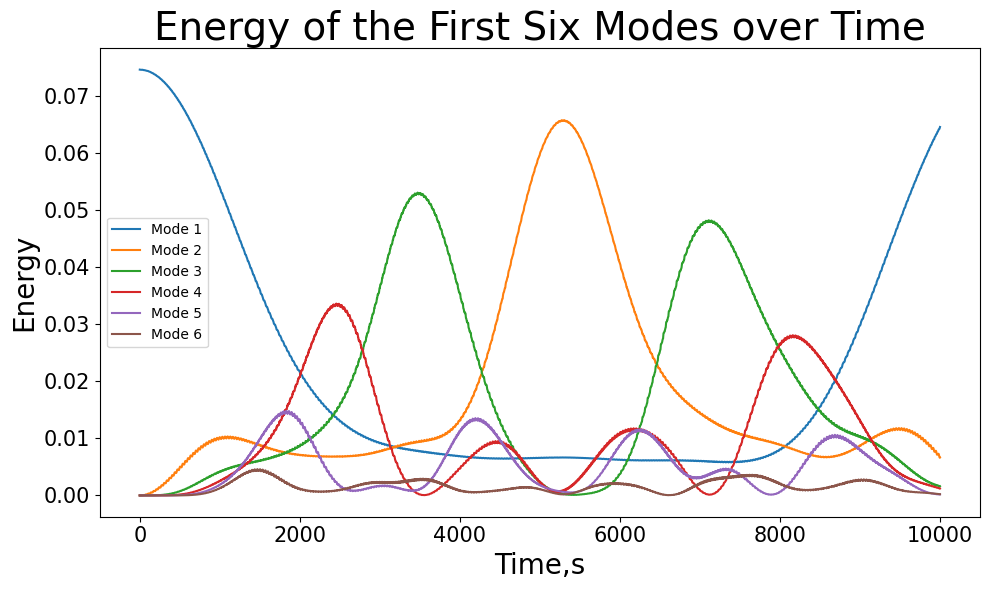

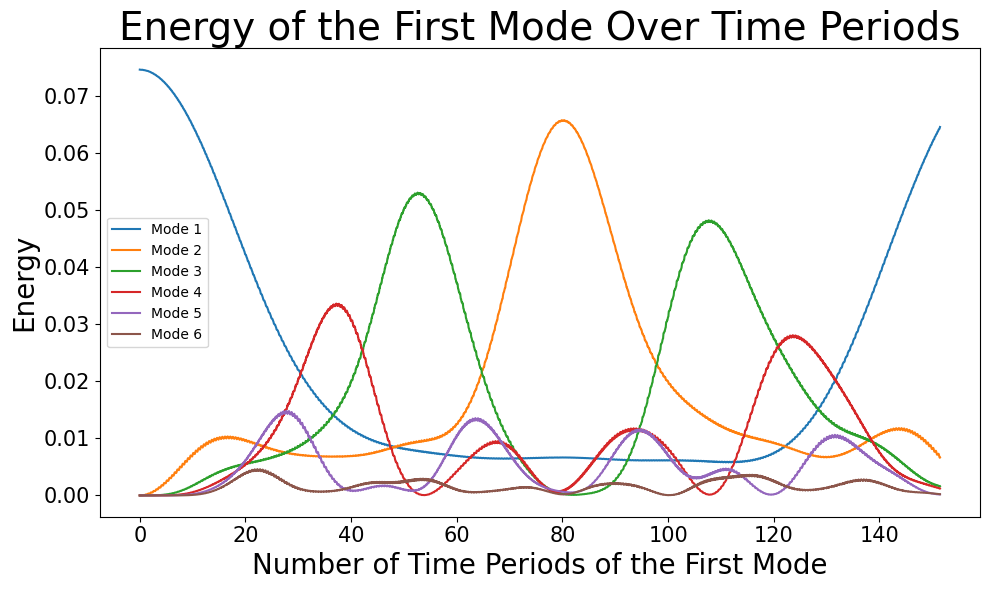

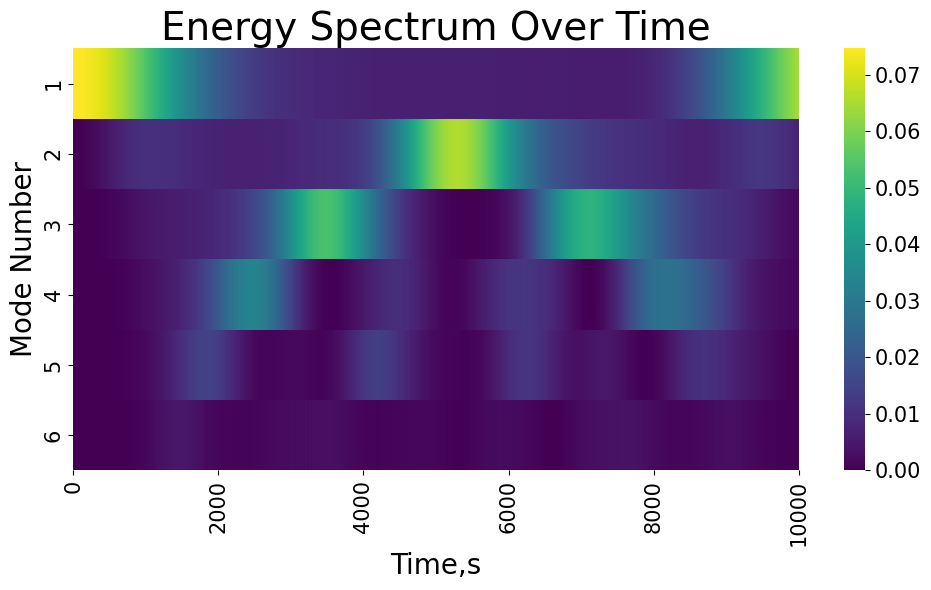

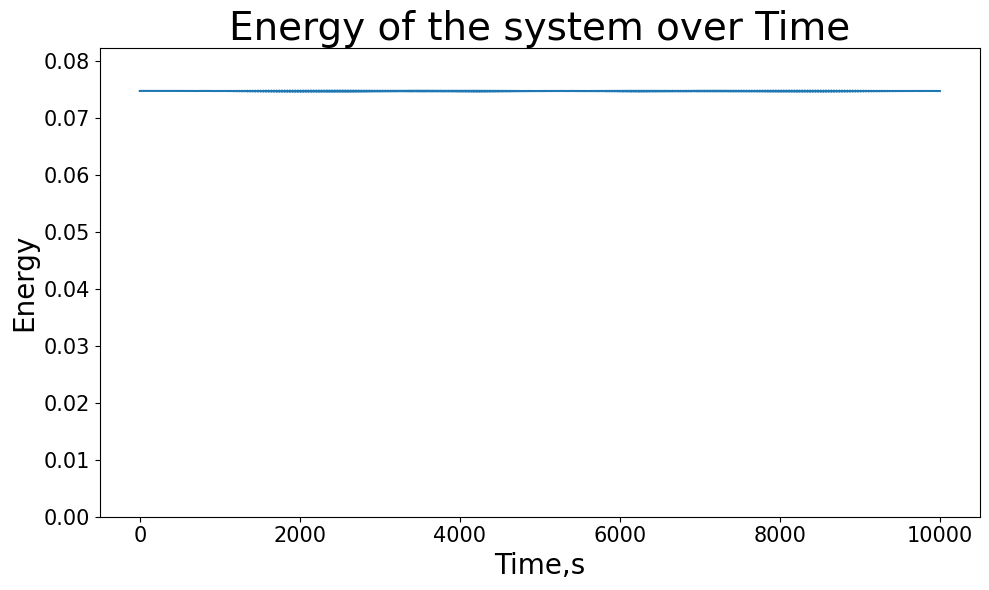

The energy at the start was 0.07470564796833765 and the energy at the end was 0.07470196210381606


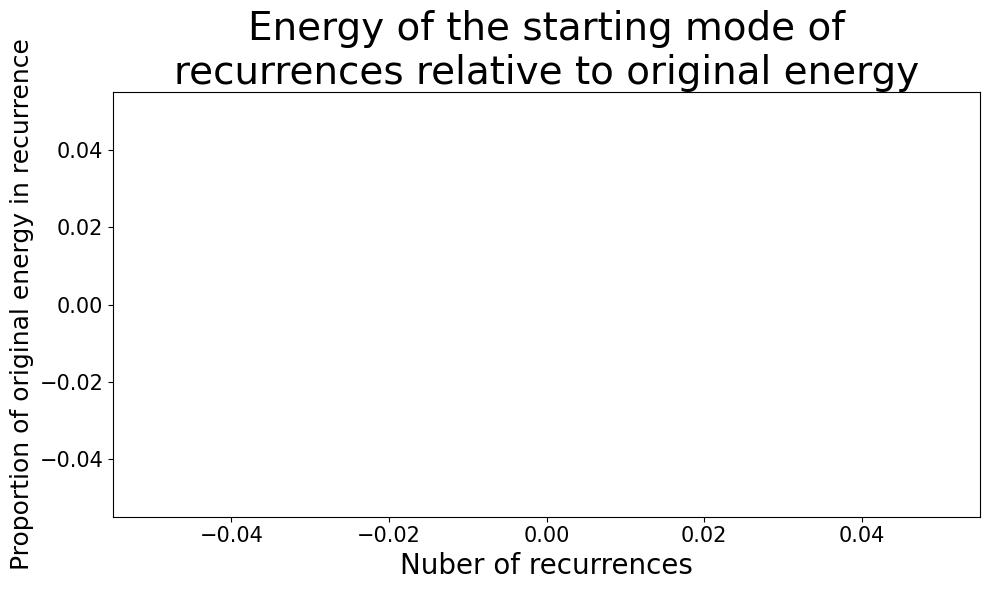

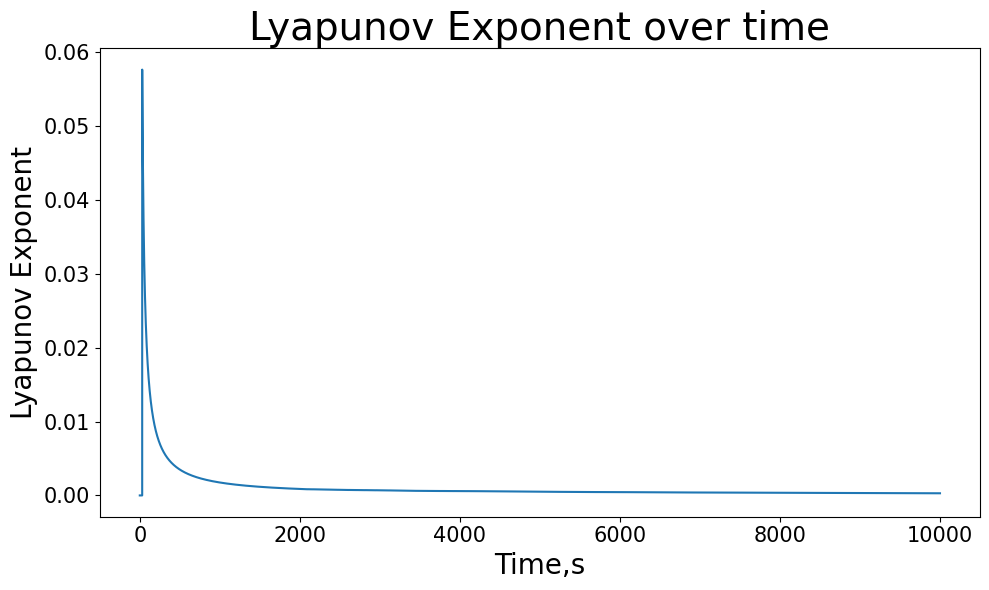

The final Lyapunov exponent was 0.00029589251011365826


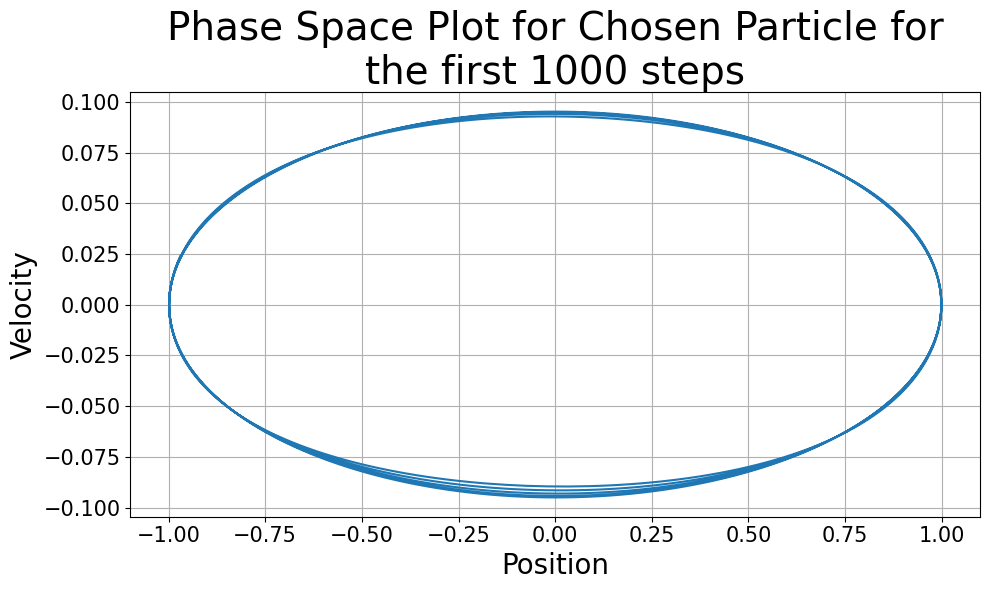

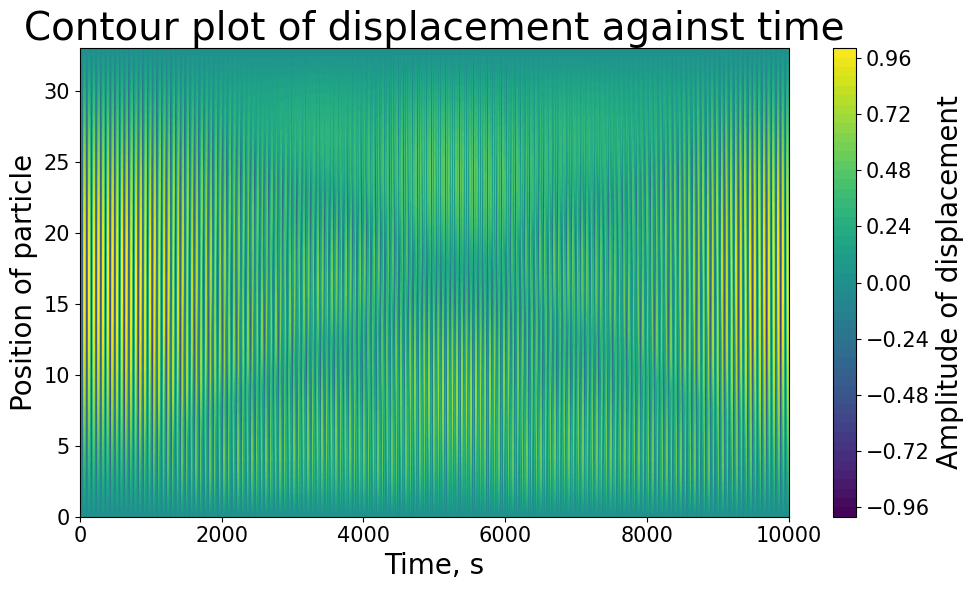

Time for processing is 171.27403934699998 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline

# Record start time of the simulation for performance measurement
start_time = time.process_time()

# Setting default font sizes on graph
plt.rcParams["axes.titlesize"] = 28 # Default title size
plt.rcParams["axes.labelsize"] = 20 # Default axis titles size
plt.rcParams["xtick.labelsize"] = 15 # Default X axis tick labels size
plt.rcParams["ytick.labelsize"] = 15 # Default Y axis tick labels size

'''
INITIALISATION FUNCTIONS

These functions prepare the simulation by initializing arrays for storing particle states,
calculating initial displacements, and setting up parameters for mode energy calculations.
'''

def initialise_arrays(num_particles, max_time, num_steps, epsilon, num_modes):
    '''
    Initializes and returns arrays for positions, velocities, accelerations, time, mode energies,
    mode frequencies, total energy, particle indices, perturbed states, peaks in mode energies, and Lyapunov exponents.
    '''
    # Initialize all required arrays with zeros or appropriate values
    pos_array = np.zeros((num_steps+1, num_particles + 2))
    vel_array = np.zeros((num_steps+1, num_particles + 2))
    acc_array = np.zeros((num_steps+1, num_particles + 2))
    time_axis = np.linspace(0, max_time, num_steps + 1)
    A_k_array = np.zeros((num_steps + 1, num_modes))
    E_k_array = np.copy(A_k_array)
    A_k_dot_array = np.copy(A_k_array)
    mode_freq = np.zeros(num_modes)
    total_energy = np.zeros(num_steps+1)
    n_array = np.arange(0, num_particles + 2, 1)
    pos_array_perturbed = np.copy(pos_array)
    vel_array_perturbed = np.copy(vel_array)
    acc_array_perturbed = np.copy(acc_array)
    peaks = []
    lyapunov = np.zeros(num_steps+1)

    return pos_array, vel_array, acc_array, time_axis, A_k_array, E_k_array, A_k_dot_array, mode_freq, total_energy, n_array, pos_array_perturbed, vel_array_perturbed, acc_array_perturbed, peaks, lyapunov


def initialise_displacements(amplitude, t, num_particles, start_mode, n_array):
    '''
    Initializes particle displacements based on a sinusoidal function for a selected mode.
    '''
    pos_array[t, 1:-1] = amplitude * np.sin(start_mode * np.pi * n_array[1:-1] / (num_particles + 1))

    return pos_array[t]


'''
PHYSICS CALCULATIONS

These functions are used to calculate the dynamics of the particle system,
including mode energies, accelerations, and total energy.
'''

def vectorised_mode_energy_calculations(pos_array, vel_array, A_k_array, E_k_array, A_k_dot_array, mode_freq, n_array, t, num_particles, num_modes):
    '''
    Calculates the mode energies of the system at a given time step in a vectorised manner.

    Returns:
    - The energy of each mode at a given time 't' and each modal frequency.
    '''
    # Define mode numbers and calculate angles for mode energy calculations
    k_modes = np.arange(1, num_modes+1)  # Mode numbers
    mode_angles = np.pi * k_modes[:, None] * n_array[None, :] / (num_particles + 1)

    # Calculate amplitude and derivative of amplitude for each mode
    sin_modes = np.sin(mode_angles)
    A_k = np.sqrt(2.0 / (num_particles + 1)) * np.dot(sin_modes, pos_array[t])
    A_k_dot = np.sqrt(2.0 / (num_particles + 1)) * np.dot(sin_modes, vel_array[t])

    # Calculate mode frequencies and energies
    mode_freq[:] = 2 * np.sin(np.pi * k_modes / (2 * num_particles + 2))
    E_k = 0.5 * (A_k_dot**2 + (mode_freq[:]**2) * A_k**2)

    # Update mode energy arrays
    A_k_array[t] = A_k
    E_k_array[t, :] = E_k
    A_k_dot_array[t] = A_k_dot

    return A_k_array[t], E_k_array[t], mode_freq


def vectorised_total_energy_calculations(pos_array, vel_array, k_quad, k_cubic, num_particles, t):
    '''
    Calculates the total energy of the system, using kinetic energy and linear,
    quadratic and cubic potential energies, at a given step in a vectorised manner.

    Returns:
    - Total energy of the system at a time 't'.
    '''
    # Difference between adjacent particles
    delta_pos = pos_array[t, 1:] - pos_array[t, :-1]

    # Energy calculations
    kinetic_energy = np.sum(0.5 * vel_array[t, 1:-1]**2) # Kinetic energy
    potential_energy = np.sum(0.5 * delta_pos**2) # Linear potential energy
    quad_energy = np.sum((k_quad / 3) * delta_pos**3) # Quadratic potential energy
    cubic_energy = np.sum((k_cubic / 4) * delta_pos**4) # Cubic potential energy

    # Total energy is the sum of all components
    total_energy[t] = potential_energy + kinetic_energy + cubic_energy + quad_energy

    return total_energy[t]


def vectorised_acceleration_calculations(pos_array, acc_array, k_quad, k_cubic, t, num_particles):
    '''
    Calculates the accelerations of the particles at a given time step using vectorised operations.
    Incorporates linear, quadratic, and cubic interaction terms.

    Returns:
    - Updated acceleration array after calculating, using the positions.
    '''
    # Define positions of left, center, and right neighbors
    left = pos_array[t, :-2]
    center = pos_array[t, 1:-1]
    right = pos_array[t, 2:]

    # Calculate accelerations based on interactions
    linear_term = left + right - 2 * center
    quadratic_term = k_quad * ((right - center)**2 - (center - left)**2)
    cubic_term = k_cubic * ((right - center)**3 - (center - left)**3)

    acc_array[t, 1:-1] = linear_term + quadratic_term + cubic_term

    return acc_array[t, :]


'''
INTEGRATION METHODS

These functions implement different numerical integration methods to evolve the system in time.
'''

def symplectic_integration_2_order(pos_array, vel_array, acc_array, t, num_particles, dt):
    '''
    Performs a second-order symplectic integration step to update the positions, velocities,
    and accelerations of the particles.

    It updates the velocity with a half step, then position and acceleration with a full step,
    velocity with another half step - these half steps have been put into one equation since
    velocity doesn't depend on position.

    Returns:
    - Updated position, velocity, and acceleration arrays for the timestep `t`.
    '''
    # Update positions and velocities using symplectic integration
    pos_array[t, :] = pos_array[t-1, :] + dt * vel_array[t-1, :] + 0.5 * acc_array[t-1, :] * dt**2
    acc_array[t, :] = vectorised_acceleration_calculations(pos_array, acc_array, k_quad, k_cubic, t, num_particles)
    vel_array[t, :] = vel_array[t-1, :] + 0.5 * (acc_array[t, :] + acc_array[t-1, :]) * dt

    return pos_array[t], vel_array[t], acc_array[t]


def symplectic_integration_4_order(pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic):
    '''
    Performs a 4th order symplectic integration for the system of particles, called the Yoshida integrator.

    The process involves a series of steps using carefully chosen coefficients to achieve a 4th order accuracy.

    It starts with a velocity half step, then a full step for position and acceleration, using appropriate coefficients.

    Returns:
    - Updated position, velocity, and acceleration arrays for the timestep `t`.
    '''

    # Yoshida coefficients
    w = 2 ** (1 / 3)
    c = [1 / (2 * (2 - w)), (1 - w) / (2 * (2 - w)), (1 - w) / (2* (2 - w)), 1 / (2 * (2 - w))]
    d = [1 / (2 - w), -w / (2 - w), 1 / (2 - w), 0]

    '''
    Integration steps
    '''
    # For each of the substeps in the Yoshida integrator
    for i in range(4):
        if i != 0:  # For the first step, we do not update velocity
            # Update velocity based on current acceleration
            vel_array[t-1, 1:-1] += d[i] * acc_array[t-1, 1:-1] * dt
        # Update position
        pos_array[t, 1:-1] = pos_array[t-1, 1:-1] + c[i] * vel_array[t-1, 1:-1] * dt

        # Calculate new accelerations based on updated positions
        acc_array[t, :] = vectorised_acceleration_calculations(pos_array, acc_array, k_quad, k_cubic, t, num_particles)

        if i < 3:  # On the last sub-step, we do not need to update positions and velocities for the next step
            # Prepare for the next sub-step by copying the updated positions and accelerations
            pos_array[t-1, :] = pos_array[t, :]
            acc_array[t-1, :] = acc_array[t, :]

    # Final update of velocity after all sub-steps
    vel_array[t, 1:-1] = vel_array[t-1, 1:-1] + d[0] * acc_array[t, 1:-1] * dt

    return pos_array[t], vel_array[t], acc_array[t]



def runge_kutta_4th_order(pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic):
    '''
    Performs a 4th order Runge-Ketta integration technique to update positions, velocities and accelerations
    of this system of particles.

    The total change in position, velocity and acceleration is calculated using four increments,
    calculated at different points within the timestep.

    These increments are computed in the function "compute_k_values".

    Returns:
    - Updated position, velocity, and acceleration arrays for the timestep `t`.
    '''
    # Function to compute the total change in position and velocity for RK4 steps
    def compute_k_values(pos, vel, dt, k_quad, k_cubic, num_particles):
        temp_pos_array = np.zeros((2, num_particles + 2))  # Temporary array for position
        temp_pos_array[0, 1:-1] = pos  # Set current positions into temporary array
        temp_acc_array = np.zeros_like(temp_pos_array)  # Temporary array for acceleration

        # Calculate new acceleration based on temporary position array
        new_acc = vectorised_acceleration_calculations(temp_pos_array, temp_acc_array, k_quad, k_cubic, 0, num_particles)[1:-1]

        k_vel = dt * new_acc
        k_pos = dt * vel
        return k_pos, k_vel

    # Initial positions and velocities
    pos = pos_array[t-1, 1:-1]
    vel = vel_array[t-1, 1:-1]

    # First set of increments
    k1_p, k1_v = compute_k_values(pos, vel, dt, k_quad, k_cubic, num_particles)

    # Second set of increments
    k2_p, k2_v = compute_k_values(pos + 0.5 * k1_p, vel + 0.5 * k1_v, dt, k_quad, k_cubic, num_particles)

    # Third set of increments
    k3_p, k3_v = compute_k_values(pos + 0.5 * k2_p, vel + 0.5 * k2_v, dt, k_quad, k_cubic, num_particles)

    # Fourth set of increments
    k4_p, k4_v = compute_k_values(pos + k3_p, vel + k3_v, dt, k_quad, k_cubic, num_particles)

    # Update positions and velocities using RK4 formula
    new_pos = pos + (k1_p + 2*k2_p + 2*k3_p + k4_p) / 6
    new_vel = vel + (k1_v + 2*k2_v + 2*k3_v + k4_v) / 6

    # Update the acceleration for the new positions
    temp_pos_array_for_acc = np.zeros((2, num_particles + 2))
    temp_pos_array_for_acc[0, 1:-1] = new_pos
    temp_acc_array_for_acc = np.zeros_like(temp_pos_array_for_acc)
    new_acc = vectorised_acceleration_calculations(temp_pos_array_for_acc, temp_acc_array_for_acc, k_quad, k_cubic, 0, num_particles)[1:-1]

    # Update the arrays with the new values
    pos_array[t, 1:-1] = new_pos
    vel_array[t, 1:-1] = new_vel
    acc_array[t, 1:-1] = new_acc

    return pos_array[t], vel_array[t], acc_array[t]


def integration_selector(integration_choice, pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic):
    '''
    This function allows the user to easily switch between integration methods by just changing a variable.
    '''
    if integration_choice == "Symplectic 2nd order":
        return symplectic_integration_2_order(pos_array, vel_array, acc_array, t, num_particles, dt)

    elif integration_choice == "Symplectic 4th order":
        return symplectic_integration_4_order(pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic)

    elif integration_choice == "Runge-Kutta 4th order":
        return runge_kutta_4th_order(pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic)


'''
ANALYSIS

This performs analyis on the given data for the Lyapunov exponents and how much energy is conserved in each super-recurrence.
'''

def divergence_measurement(pos_array, pos_array_perturbed, vel_array, vel_array_perturbed, epsilon, renormalisations, log_divergence_sum, t, lyapunov):
    '''
    Measures the divergence between two sets of position and velocity arrays (original and perturbed) to calculate Lyapunov exponents.

    This function calculates the divergence between the original and perturbed trajectories of a dynamical system at time t.
    If the divergence exceeds a specified threshold (epsilon), the perturbed state is rescaled to maintain a small separation.
    This rescaling contributes to the calculation of Lyapunov exponents, which quantify the rate of separation of infinitesimally close trajectories.

    Returns:
    - Updated lyapunov array with the new value for the current timestep.
    '''
    # Calculate the difference between original and perturbed states
    delta_pos_pert = pos_array[t, :] - pos_array_perturbed[t, :]
    delta_vel_pert = vel_array[t, :] - vel_array_perturbed[t, :]

    # Calculate the Euclidean norm of the divergence
    divergence = np.sqrt(np.sum(delta_pos_pert**2 + delta_vel_pert**2))

    # Rescale perturbations if perturbed solution strays too far from unperturbed solution
    if divergence > epsilon:

        scaling_factor = epsilon / divergence
        # Rescale perturbed position and velocity
        pos_array_perturbed[t, :] = pos_array[t, :] - scaling_factor * delta_pos_pert
        vel_array_perturbed[t, :] = vel_array[t, :] - scaling_factor * delta_vel_pert

        # Update the sum of logarithms for Lyapunov exponent calculation
        log_divergence_sum += np.log(divergence / epsilon)
        renormalisations += 1

    # Calculate the Lyapunov exponent if not towards the beginning, to stop a spike in the Lyapunov exponent at the beginning of the simulation
    if t > 100:
        lyapunov[t] = log_divergence_sum / (t * dt)

    return lyapunov, log_divergence_sum, renormalisations


def find_peak(peaks, data, sigma):
    '''
    Identifies peaks in a dataset after applying a Gaussian filter for smoothing.

    This function smooths the input data using a Gaussian filter with a specified standard deviation (sigma).
    It then identifies peaks in the smoothed data, ensuring that each peak is also a peak in the original data and exceeds 70% of the initial data value. This method helps in detecting significant peaks in noisy data.

    Returns:
    - Updated list of peaks with the newly identified peaks from the dataset.
    '''
    # Apply Gaussian filter to smooth the data
    smoothed_data = gaussian_filter1d(data, sigma)

    # Iterate through the smoothed data to identify peaks
    for i in range(1, len(smoothed_data) - 1):
        # Check if current point is a peak in both smoothed and original data
        if smoothed_data[i-1] < smoothed_data[i] > smoothed_data[i+1] and data[i] > data[0] * 0.4:
            # Append the maximum value around the peak to the peaks list
            peaks.append(np.max(data[i-50:i+50]))

    # Normalize the identified peaks relative to the initial data segment
    peaks /= np.max(data[0:100])

    return peaks



'''
VISUALISATION

These functions allow the user to see various qualities of the system, including the energy of each individual mode over time,
total energy, the energy of each super-recurrence, the Lyapunov exponents, the positions as a contour plot,
the phase space of an individual particle and an animation of the positions for a short period of the simulation.
'''

def mode_energy_plots(E_k_array, time_axis, num_modes):
    '''
    This plots the energy of the first few modes over time.
    '''
    plt.figure(figsize=(10, 6))
    for mode in range(num_modes):
        plt.plot(time_axis, E_k_array[:, mode], label=f"Mode {mode + 1}")
    plt.xlabel("Time,s")
    plt.ylabel("Energy")
    plt.title("Energy of the First Six Modes over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()


def mode_energy_plot_periods(E_k_array, time_axis, mode_freq, num_modes):
    '''
    Plots the energy of the first mode over a number of time periods of the first mode,
    '''
    # Calculate the period of the first mode using its frequency
    periods_axis = mode_freq[0] * time_axis / (2 * np.pi)

    plt.figure(figsize=(10, 6))

    for mode in range(num_modes):
        plt.plot(periods_axis, E_k_array[:, mode], label=f"Mode {mode + 1}")
    plt.xlabel("Number of Time Periods of the First Mode")
    plt.ylabel("Energy")
    plt.title("Energy of the First Mode Over Time Periods")
    plt.legend()
    plt.tight_layout()
    plt.show()


def mode_energy_heatmap(E_k_array, num_modes, max_time):
    '''
    This creates a heatmap, showing the energy spectrum over time for different modes, it's just a different way of visualising energy of the modes.
    '''
    mode_numbers = np.arange(1, num_modes + 1)
    time_steps = np.linspace(0, max_time, 10)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(E_k_array.T, cmap="viridis", yticklabels=mode_numbers)
    ax.set_xticks(np.linspace(0, E_k_array.shape[0], 6))
    ax.set_xticklabels([f"{int(np.round(t))}" for t in np.linspace(0, max_time, 6)])
    plt.xlabel("Time,s")
    plt.ylabel("Mode Number")
    plt.title("Energy Spectrum Over Time")
    plt.tight_layout()
    plt.show()


def total_energy_plot(total_energy, time_axis):
    '''
    Plots the total energy over time, to see if it's conserved.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, total_energy)
    plt.xlabel("Time,s")
    plt.ylabel("Energy")
    plt.title("Energy of the system over Time")
    plt.ylim(0.0, 1.1 * total_energy[0])
    plt.tight_layout()
    plt.show()


def recurrence_energy_plot(peaks):
    '''
    Plots the energy of starting modes' recurrences relative to the original energy.
    '''
    recurrence_no = np.arange(1, len(peaks)+1, 1)
    plt.figure(figsize=(10, 6))
    plt.plot(recurrence_no, peaks, linestyle="-", marker="o")
    plt.xlabel("Nuber of recurrences")
    plt.ylabel("Proportion of original energy in recurrence", fontsize=18)
    plt.title("Energy of the starting mode of\nrecurrences relative to original energy")
    plt.tight_layout()
    plt.show()


def lyapunov_plot(lyapunov, time_axis):
    '''
    Plots the Lyapunov exponent over time.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, lyapunov, linestyle="-")
    plt.xlabel("Time,s")
    plt.ylabel("Lyapunov Exponent")
    plt.title("Lyapunov Exponent over time")
    plt.tight_layout()
    plt.show()


def pos_contour(time_axis, pos_array, n_array):
    '''
    Creates a contour plot of the positions against time for each particle.
    '''
    T, N = np.meshgrid(time_axis, n_array)
    plt.figure(figsize=(10, 6))
    plt.contourf(T, N, pos_array.T, cmap="viridis", levels = 50)
    plt.xlabel("Time, s")
    plt.ylabel("Position of particle")
    plt.colorbar(label = "Amplitude of displacement")
    plt.title("Contour plot of displacement against time")
    plt.tight_layout()
    plt.show()


def phase_space_plot(pos_array, vel_array, particle, phase_steps):
    '''
    This generates a phase space plot by plotting position against velocity for a given particle for phase_steps number of steps.
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(pos_array[0:1000, particle-1], vel_array[0:phase_steps, particle-1])
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Phase Space Plot for Chosen Particle for\nthe first {phase_steps} steps")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def animation_position(num_particles, pos_array, anim_time_limit, dt, n_array):
    '''
    This function animates the position of particles along a line, providing a visual representation
    of their dynamics over time. The animation is saved as an MP4 file.
    '''
    fig = plt.figure(figsize=(10, 6), dpi=70)
    plt.axis([0, num_particles + 2, -1.1 * np.max(abs(pos_array)), 1.1 * np.max(abs(pos_array))])

    particle_image = []
    # Loop through each time step up to the animation time limit to plot particle positions
    for d in pos_array[0:int(anim_time_limit/dt), :]:
        # Each frame in the animation shows the positions of all particles at a given time step
        particle_image.append(plt.plot(n_array, d, "ro"))

    # Create the animation
    anim = animation.ArtistAnimation(fig, particle_image, interval=10, repeat=False, blit=True)

    # Save the animation to a file
    anim.save("particle_animation.mp4", writer="ffmpeg")

    plt.close() # Close the plot to prevent it from displaying in a notebook or script output


# ***************************************END OF FUNCTIONS***************************************
# ***************************************END OF FUNCTIONS***************************************
# ***************************************END OF FUNCTIONS***************************************
# ***************************************END OF FUNCTIONS***************************************
# ***************************************END OF FUNCTIONS***************************************



'''
MAIN SIMULATION LOOP

The main part of the script sets initial conditions, selects an integration method,
and iterates over time steps to simulate the particle dynamics.
'''


'''
PARAMETERS
'''
num_particles = 32 # Number of moving particles
max_time = 10000 # Time for the simulation to run
dt = 0.3 # Time-step
log_divergence_sum = 0 # Logarithms for Lyapunov exponent calculation
renormalisations = 0 # Number of times the perturbed solution strays too far from the unperturbed solution
num_modes = 6 # Number of modes for energy to calcualte
k_quad = 0.25 # Coefficient for quadratic force
k_cubic = 0.0 # Coefficient for cubic force
start_mode = 1.0 # The initial mode for displacement of particles
num_steps = int(max_time / dt) # Calculating total number of timesteps
epsilon = 0.1 # Perturbation to the perturbed system
anim_time_limit = 500 # How many time-steps the animation shows
amplitude = 1.0 # Amplitude of the inital displacement
phase_space_particle = 17 # Particle for which to plot the phase space
phase_steps = 1000 # Number of steps for the phase diagram to show

integration_choice = "Symplectic 2nd order" # Integration technique choice


'''
INITIALISATION

Initialising arrays and positions (perturbed and unperturbed), to start the simulation.
Perturbed position is used to calculate Lyapunov exponents.
'''

# Initialise arrays to store all data necessary
pos_array, vel_array, acc_array, time_axis, A_k_array, E_k_array, A_k_dot_array, mode_freq, total_energy, n_array, pos_array_perturbed, vel_array_perturbed, acc_array_perturbed, peaks, lyapunov = initialise_arrays(num_particles, max_time, num_steps, epsilon, num_modes)

# Initialise particle displacements
pos_array[0, :] = initialise_displacements(amplitude, 0, num_particles, start_mode, n_array)

# Initialise perturbed particles displacements, with all particles perturbed by 0.1, except the stationary, end particles
pos_array_perturbed[0, :] = initialise_displacements(amplitude, 0, num_particles, start_mode, n_array)
pos_array_perturbed[0, 1:-1] += epsilon


'''
INITIAL CALCULATIONS

Calculating all values at the t=0 state.

Values calculated at each step:
- Energy in each mode in unperturbed state
- Total energy of the system
- Acceleration of each particle in perturbed and unperturbed state (normally happens within the integration function)
- The Lyapunov value
'''

# Calculate mode energy for the initial state, assuming 'dt' is not needed here based on your function definition
A_k_array[0], E_k_array[0], mode_freq = vectorised_mode_energy_calculations(pos_array, vel_array, A_k_array, E_k_array, A_k_dot_array, mode_freq, n_array, 0, num_particles, num_modes)

# Calculate total energy for the initial state
total_energy[0] = vectorised_total_energy_calculations(pos_array, vel_array, k_quad, k_cubic, num_particles, 0)

# Calculate acceleration for the initial state (perturbed and unperturbed)
acc_array[0] = vectorised_acceleration_calculations(pos_array, acc_array, k_quad, k_cubic, 0, num_particles)
acc_array_perturbed[0] = vectorised_acceleration_calculations(pos_array_perturbed, acc_array_perturbed, k_quad, k_cubic, 0, num_particles)

# Calculate the Lyapunov exponent for the initial state
lyapunov, log_divergence_sum, renormalisations = divergence_measurement(pos_array, pos_array_perturbed, vel_array, vel_array_perturbed, epsilon, renormalisations, log_divergence_sum, 0, lyapunov)


'''
TIME LOOP

Loop simulating the system and calculating the necessary values
'''

for t in range(1, num_steps+1):

    # Calculate the new particle positions, velocities and accelerations for perturbed and unperturbed systems
    pos_array[t], vel_array[t], acc_array[t] = integration_selector(integration_choice, pos_array, vel_array, acc_array, t, num_particles, dt, k_quad, k_cubic)
    pos_array_perturbed[t], vel_array_perturbed[t], acc_array_perturbed[t] = integration_selector(integration_choice, pos_array_perturbed, vel_array_perturbed, acc_array_perturbed, t, num_particles, dt, k_quad, k_cubic)

    # Calculate mode energy for each time step
    vectorised_mode_energy_calculations(pos_array, vel_array, A_k_array, E_k_array, A_k_dot_array, mode_freq, n_array, t, num_particles, num_modes)

    # Calculate the total energy in the system for each time step
    vectorised_total_energy_calculations(pos_array, vel_array, k_quad, k_cubic, num_particles, t)

    # Calculate the difference between the two paths
    lyapunov, log_divergence_sum, renormalisations = divergence_measurement(pos_array, pos_array_perturbed, vel_array, vel_array_perturbed, epsilon, renormalisations, log_divergence_sum, t, lyapunov)


# Find the energies of each superrecurrence
# Uncomment when there is more than one super-recurrence, since you need more than one point for a graph
peaks = find_peak(peaks, E_k_array[:, int(start_mode-1)], 300)


'''
PLOTS
'''
# Plot of energy of first few modes against time
mode_energy_plots(E_k_array, time_axis, num_modes)

# Plot of energy of first few modes against time period of first mode
mode_energy_plot_periods(E_k_array, time_axis, mode_freq, num_modes)

# Heat map of energy spectrum over time
mode_energy_heatmap(E_k_array, num_modes, max_time)

# Plot of total energy against time
total_energy_plot(total_energy, time_axis)
energy_start = np.mean(total_energy[0:1000])
energy_end = np.mean(total_energy[-1000:-1])
print(f"The energy at the start was {energy_start} and the energy at the end was {energy_end}")

# Plot of energy of super-recurrences compared to original energy
# Uncomment when find_peaks is also uncommented
recurrence_energy_plot(peaks)

# Plot showing Lyapunov exponents over time
lyapunov_plot(lyapunov, time_axis)

# Find the final Lyapunov exponent
final_lyapunov = np.mean(lyapunov[-1000:-1])
print(f"The final Lyapunov exponent was {final_lyapunov}")

# Plot showing phase space of a given particle
phase_space_plot(pos_array, vel_array, phase_space_particle, phase_steps)

# Plot showing the contour plot of positions of particles against time
pos_contour(time_axis, pos_array, n_array)

# Animation of position of particles in a line over a specified time
# THIS INCREASES TIME TO RUN BY A LOT
# Uncomment when wanted
animation_position(num_particles, pos_array, anim_time_limit, dt, n_array)

# CPU Time
end_time = time.process_time()
Processing_time = end_time - start_time
print(f"Time for processing is {Processing_time} seconds")
